# Gravitational Waves detection

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import h5py
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

C:\Users\loren\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\loren\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


I read a dataset containing simulated gravitational-wave signals from merging black holes, through the package *h5py*.

In [2]:
dataset = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')

In [3]:
list(dataset.keys())

['chi1x',
 'chi1y',
 'chi1z',
 'chi2x',
 'chi2y',
 'chi2z',
 'dec',
 'default',
 'det',
 'iota',
 'mtot',
 'psi',
 'q',
 'ra',
 'snr',
 'z']

Since the data is very heavy, i can do a downsample, in order to increase the speed of computations.

In [4]:
mtot = dataset['mtot'][:1000]
q = dataset['q'][:1000]
z = dataset['z'][:1000]
det = dataset['det'][:1000]
snr = dataset['snr'][:1000]
iota = dataset['iota'][:1000]
psi = dataset['psi'][:1000]
ra = dataset['ra'][:1000]
dec = dataset['dec'][:1000]

I explore some of the variables.

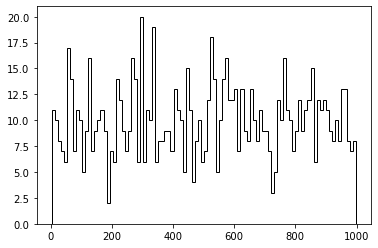

In [5]:
plt.hist(mtot, histtype = 'step', color = 'k', bins=100);

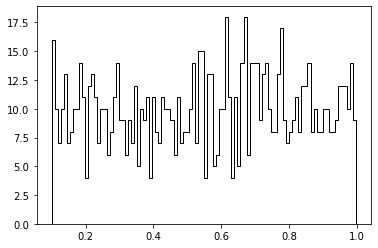

In [6]:
plt.hist(q, histtype = 'step', color = 'k', bins=100);

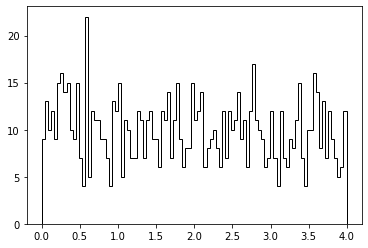

In [7]:
plt.hist(z, histtype = 'step', color = 'k', bins=100);

I run now a classifier on the variable *det*, an array of 0s and 1s, which respectively tell me if a source is detectable (SNR > 12) or not (SNR < 12).

**Decision Tree Classifier**

In [41]:
# i take the total mass and the redshift
X = np.hstack([mtot[:, np.newaxis], z[:, np.newaxis]])
y = det

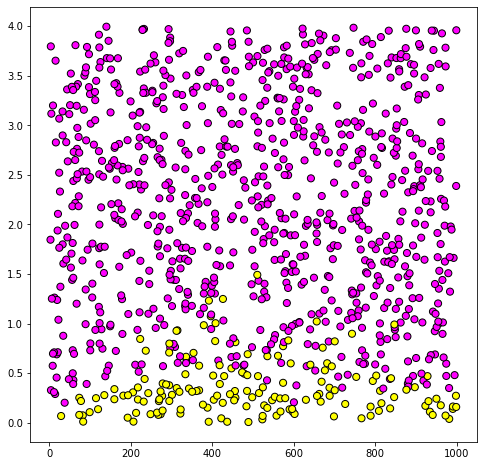

In [42]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring', edgecolor='k')
plt.show();

I run a Cross-Validation in order to take the best depth parameter to give to the Decision Tree Classifier.

In [10]:
from sklearn.model_selection import GridSearchCV

clf = DecisionTreeClassifier()
drange = np.arange(1,21)  #Complete

grid = GridSearchCV(clf, param_grid={'max_depth': drange}, cv=5) #Complete
grid.fit(X, y)

best = grid.best_params_['max_depth']
print("best parameter choice:", best)

best parameter choice: 4


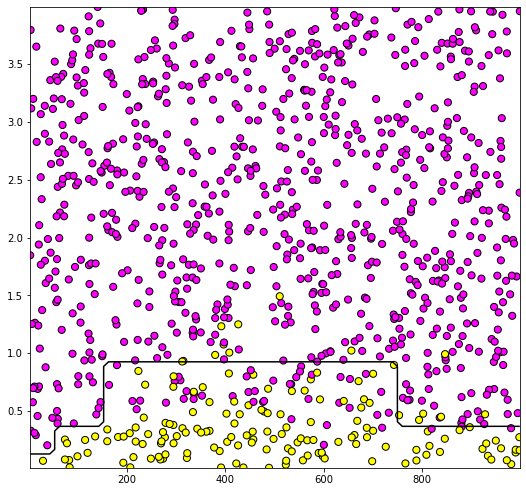

In [11]:
dt = DecisionTreeClassifier(random_state=0, max_depth=best, 
                            criterion='entropy')
dt.fit(X, y)
yprob = dt.predict_proba(X) # If we wanted probabilities rather than the discrete classes

#xlim = (0, 1)
#ylim = (-1, 5)
xlim = (np.min(X[:, 0]), np.max(X[:, 0])) 
ylim = (np.min(X[:, 1]), np.max(X[:, 1]))


xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 51),
                     np.linspace(ylim[0], ylim[1], 51))
xystack = np.vstack([xx.ravel(),yy.ravel()])
Xgrid = xystack.T

Z = dt.predict(Xgrid)
Z = Z.reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(111)
im = ax.scatter(X[:, 0], X[:, 1], c=y, s=50, 
                cmap=plt.cm.spring, zorder=2, edgecolor='k')

ax.contour(xx, yy, Z, [0.5], colors='k')
plt.show()

The result is nice, bu i can try to improve it with **bagging**.

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [27]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

y_pred_tree = tree_clf.predict(X_test)

In [28]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), 
    n_estimators=500, max_samples=100, 
    bootstrap=True, random_state=42, n_jobs=-1)

%timeit bag_clf.fit(X_train, y_train)

y_pred_bag = bag_clf.predict(X_test)

508 ms ± 63.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
print("With bagging, the accuracy results to be: " + str(accuracy_score(y_test, y_pred_bag)))
print("Without bagging, the accuracy results to be: " + str(accuracy_score(y_test, y_pred_tree)))

With bagging, the accuracy results to be: 0.968
Without bagging, the accuracy results to be: 0.936


The accuracies tell me that with bagging, the classifier performs slightly better. But let's plot the decision boundary and the full result.

In [30]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[np.min(X[:, 0]), np.max(X[:, 0]), 
                                            np.min(X[:, 1]), np.max(X[:, 1])], 
                           alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 
             "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 
             "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

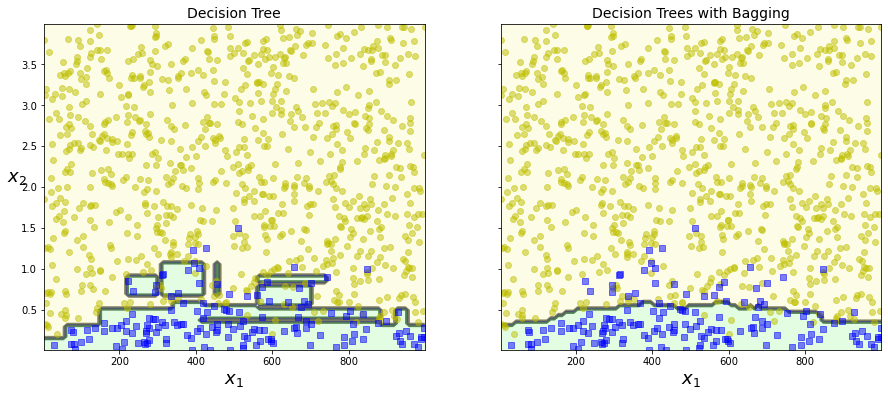

In [31]:
fix, axes = plt.subplots(ncols=2, figsize=(15,6), sharey=True)

plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)

plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)

plt.ylabel("")
plt.show()

This is already a better result, but it can be seen that some sporadic points are completely ignored by bagging. 

I try now with a **Random Forest Process**

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
n = np.arange(10, 201, 10)

grid = GridSearchCV(clf, param_grid={'n_estimators': n}, cv=5)
grid.fit(X_train, y_train)

best = grid.best_params_['n_estimators']
print("best parameter choice:", best)

best parameter choice: 140


In [35]:
ranfor_clf = RandomForestClassifier( 
    n_estimators=best, max_samples=100, 
    bootstrap=True, random_state=42, n_jobs=-1)

%timeit ranfor_clf.fit(X_train, y_train)

y_pred_ranfor = ranfor_clf.predict(X_test)

517 ms ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


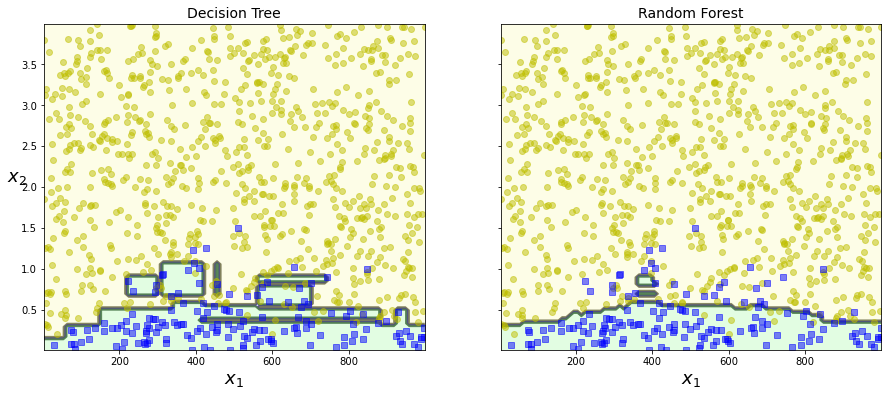

In [37]:
fix, axes = plt.subplots(ncols=2, figsize=(15,6), sharey=True)

plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)

plt.sca(axes[1])
plot_decision_boundary(ranfor_clf, X, y)
plt.title("Random Forest", fontsize=14)

plt.ylabel("")
plt.show()

I can notice that the two ensamble learners (Bagging & Random Forest) draw a pretty similar decision boundary, both improving the performance with respect to the classifier alone.

I can now try with a regressor on the feature *SNR* instead of a classifier on *det*.

In [184]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.ticker as ticker
from sklearn.preprocessing import StandardScaler

X = np.hstack([mtot[:, np.newaxis], z[:, np.newaxis], q[:, np.newaxis]])
y = snr

X_train = X[:800]
y_train = y[:800]

X_test = X[800:]
y_test = y[800:]

#------------------------------------------------------------

# Compute the results
def compute_forest(depth):
    rms_test = np.zeros(len(depth))
    rms_train = np.zeros(len(depth))
    i_best = 0
    y_fit_best = None

    for i, d in enumerate(depth):
        clf = RandomForestRegressor(n_estimators=100,
                                    max_depth=d, random_state=0)
        clf.fit(X_train, y_train)

        y_fit_train = clf.predict(X_train)
        y_fit = clf.predict(X_test)
        rms_train[i] = np.mean(np.sqrt((y_fit_train - y_train) ** 2))
        rms_test[i] = np.mean(np.sqrt((y_fit - y_test) ** 2))

        if rms_test[i] <= rms_test[i_best]:
            i_best = i
            y_fit_best = y_fit

    return rms_test, rms_train, i_best, y_fit_best

depth = np.arange(1, 21)
rms_test, rms_train, i_best, y_fit_best = compute_forest(depth)
best_depth = depth[i_best]

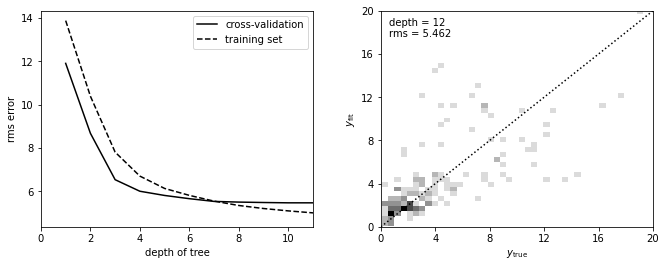

In [185]:
# Plot the results
fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(wspace=0.25,
                    left=0.1, right=0.95,
                    bottom=0.15, top=0.9)

# left panel: plot cross-validation results
ax = fig.add_subplot(121)
ax.plot(depth, rms_test, '-k', label='cross-validation')
ax.plot(depth, rms_train, '--k', label='training set')
ax.legend(loc=1)

ax.set_xlabel('depth of tree')
ax.set_ylabel('rms error')

ax.set_xlim(0, 11)
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))

# right panel: plot best fit
ax = fig.add_subplot(122)

edges = np.linspace(y_test.min(), y_test.max(), 501)
H, ys_bins, yp_bins = np.histogram2d(y_test, y_fit_best, bins=edges)
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto', 
           extent=[ys_bins[0], ys_bins[-1], ys_bins[0], ys_bins[-1]],
           cmap=plt.cm.binary)

ax.plot([0, 30], [0, 30], ':k')
ax.text(0.03, 0.97, "depth = %i\nrms = %.3f" % (best_depth, rms_test[i_best]),
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlabel(r'$y_{\rm true}$')
ax.set_ylabel(r'$y_{\rm fit}$')

ax.set_xlim(0, 20)
ax.set_ylim(0, 20)

ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))

plt.show()

In the left panel i notice a nice behavior of the RMS errors as a function of the depths. The model seems to be learning well, because the RMS on the test set gets higher than the one on the training set.

In the right panel i can see instead an high dispersion caused by the generally high RMS error. This problem could imputated, for example, to a lack of parameters in the definition of the regressor.

I can now ask myself if applying PCA could improve the performances.

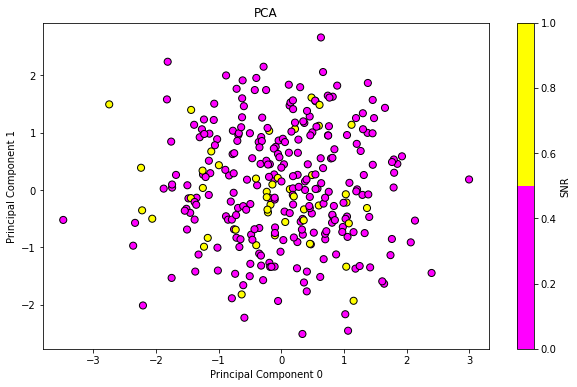

Expained fractional variance of data encapsulated in the eigenvalues: [0.1584509  0.15649437 0.14748338 0.14066792 0.14039999 0.12991351
 0.12658994]


In [213]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

X = np.hstack([mtot[:, np.newaxis], z[:, np.newaxis], q[:, np.newaxis], iota[:, np.newaxis], psi[:, np.newaxis], 
              ra[:, np.newaxis], dec[:, np.newaxis]])
y = det

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

plt.figure(figsize=(10, 6))

scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap=plt.get_cmap('spring', len(np.unique(y))), edgecolor='k', s=50)
plt.colorbar(scatter, label='SNR')
plt.xlabel('Principal Component 0')
plt.ylabel('Principal Component 1')
plt.title('PCA')
plt.show()

evals = pca.explained_variance_ratio_ 
print('Expained fractional variance of data encapsulated in the eigenvalues: ' + str(evals))

Here i can see that applying PCA on this set of data, seems to not improve the performance, because of the low variance encapsulated in the eigenvalues.